# Minimizing the radius of a $2.00\,M_{\odot}$ neutron star for an extremal EoS -- varying $\epsilon_{\Delta}$ and $c_{s,\,\mathrm{upper}}$

In [1]:
# For measuring runtime
import time
start_time = time.time()

In [2]:
import numpy as np
from scipy.integrate import solve_ivp, odeint, quad
from astropy.constants import G, c
from numpy import pi
import astropy.units as u
import matplotlib.pyplot as plt
import sys
import math
np.set_printoptions(threshold=sys.maxsize)
from scipy import optimize
from sympy import symbols, diff
import csv

In [3]:
# Using natural units
# 197 MeV * fm = 1
# 1 fm = 1 / (197 MeV)
# 3e8 m = 1 s
# 3e8 m / s = 1
# 1 J = 1 kg * (m / s)^2
# 1 J = 1 / 9e16 kg

natural = [(u.MeV, u.fm ** (-1), lambda fm_inverse: 1 / 197 * fm_inverse, lambda MeV: 197 * MeV),
           (u.m, u.s, lambda s: 1 / c.value * s, lambda m: c.value * m),
           (u.kg, u.J, lambda J: c.value ** 2 * J, lambda kg: 1 / c.value ** 2 * kg),
           (u.m / u.s, u.dimensionless_unscaled, lambda dimensionless: 1 / c.value * dimensionless, lambda v: c.value * v),
           (u.fm, u.MeV ** (-1), lambda MeV_inverse: 1 / 197 * MeV_inverse, lambda fm: 197 * fm)
          ]

G = (G.value * (1 * u.m / u.s).to(u.dimensionless_unscaled, equivalencies = natural) ** 2 * (1 * u.m).to(u.fm).to(1 / u.MeV, equivalencies = natural) / (1 * u.kg).to(u.J, equivalencies = natural).to(u.MeV))
G = G.value

## Functions to find numerical EoS arrays for piecewise EoS given some number density (in natural units)

In [4]:
# Non-rest-mass energy E
def find_E(num_density):
    result = a * (num_density / n_0) ** alpha + b * (num_density / n_0) ** beta
    return result

# Energy density epsilon
def find_epsilon(num_density):
    E = find_E(num_density)
    result = num_density * (E + m_N)
    return result

# Chemical potential
def find_chem_potential(num_density):
    result = a * (alpha + 1) * (num_density / n_0) ** alpha + b * (beta + 1) * (num_density / n_0) ** beta + m_N
    return result

# Pressure
# Pass in epsilon_D in MeV / fm^3
def find_pressure(num_density, epsilon_D, c_s_Upper):
    epsilon = find_epsilon(num_density)
    chem_potential = find_chem_potential(num_density)

    epsilon_Delta = epsilon_D * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3
    
    num_density_c = num_density_from_energy_density(epsilon_c.value) * u.MeV ** 3
    chem_potential_c = find_chem_potential(num_density_c)
    pressure_c = - epsilon_c + chem_potential_c * num_density_c
    
    # Piece-wise extremal EoS
    if epsilon.value < epsilon_c.value:
        result = - epsilon + chem_potential * num_density    # Gandolfi nuclear EoS
    else:
        if epsilon.value < epsilon_Delta.value:
            result = pressure_c    # Flat EoS
        else:
            result = pressure_c + c_s_Upper * (epsilon - epsilon_Delta)    # EoS slope = c_s_Upper
    
    return result

In [5]:
# Finding number density as a function of energy density

def energy_density_minus_target_epsilon(n, target_epsilon):
    n = n * u.MeV ** 3
    result = find_epsilon(n).value - target_epsilon
    return result

# Takes input parameter epsilon in MeV^4
def num_density_from_energy_density(epsilon):
    b = 10 ** 12
    if energy_density_minus_target_epsilon(0, epsilon) > 0:
        print(f"find_epsilon is {find_epsilon(0 * u.MeV ** 3)} and epsilon is {epsilon}.")
        return
    result = optimize.brentq(energy_density_minus_target_epsilon,
                             0,
                             b,
                             args = (epsilon,))
    return result

## Plotting the EoS

In [6]:
# epsilon = []
# pressure = []

# n = np.logspace(-0.3, 1, num = 200) * n_0

# for num_density in n:
#     epsilon_in_MeV = find_epsilon(num_density).value
#     epsilon_in_MeV_and_fm = epsilon_in_MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
#     epsilon.append(epsilon_in_MeV_and_fm.value)
#     pressure_in_MeV = find_pressure(num_density, epsilon_D).value
#     pressure_in_MeV_and_fm = pressure_in_MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
#     pressure.append(pressure_in_MeV_and_fm.value)

In [7]:
# fig, ax = plt.subplots(figsize = (8, 8))

# epsilon_c_MeV_and_fm = epsilon_c * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
# epsilon_delta_MeV_and_fm = epsilon_delta * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
# ax.set_title("Equation of state", fontsize = 15);
# ax.set_xlabel(r"$\mathrm{Energy\,density}\,\epsilon\,\left(\mathrm{MeV/\,fm^3}\right)$", fontsize = 15);
# ax.set_ylabel(r"$\mathrm{Pressure\,\left(MeV/\,fm^3\right)}$", fontsize = 15);
# ax.set_xlim(0, epsilon_delta_MeV_and_fm.value + 25);
# ax.set_ylim(0, 25);
# ax.plot(epsilon, pressure, label = "EoS");
# ax.axvline(x = epsilon_c_MeV_and_fm.value, color = "red", linewidth = 0.5, label = r"$\epsilon_{c}=150\,\mathrm{MeV/\,fm^3}$");
# ax.axvline(x = epsilon_delta_MeV_and_fm.value, color = "green", linewidth = 0.5, label = r"$\epsilon_{\Delta}=650\,\mathrm{MeV/\,fm^3}$");
# ax.legend(fontsize = 15);

# plt.savefig("Piecewise_EoS.pdf", bbox_inches = "tight");
# plt.savefig("Piecewise_EoS.jpg", bbox_inches = "tight");

## Generalized TOV

In [8]:
# r = distance from center
# m = cumulative mass enclosed within distance r from center
# p = pressure at distance r from center
# epsilon = energy density at distance r from center

# TOV coded to be compatible w/ cgs units, but can't explicitly give units in code b/c solve_ivp() throws errors

def TOV(r, p_and_m, n_central, epsilon_D, c_s_Upper):
    p = p_and_m[0]
    m = p_and_m[1]
    
    if num_density_from_pressure(p, r, n_central, epsilon_D, c_s_Upper) is None:
        return [0, 0]
        
    n = num_density_from_pressure(p, r, n_central, epsilon_D, c_s_Upper) * u.MeV ** 3
    epsilon = find_epsilon(n).value
    print(f"number density is {n}")
    rel_factors = (1 + p / epsilon) * (1 + 4 * pi * r ** 3 * p / m) * (1 - 2 * G * m / r) ** (-1)
    p_result = - G * epsilon * m / r ** 2 * rel_factors
    m_result = 4 * pi * r ** 2 * epsilon
    return [p_result, m_result]

In [9]:
# Finding number density as a function of pressure

def pressure_minus_target_p(n, target_p, epsilon_D, c_s_Upper):
    n = n * u.MeV ** 3
    result = find_pressure(n, epsilon_D, c_s_Upper).value - target_p
    return result

def find_pressure_brentq_b(n_central):
    slope = (0.125 * 10 ** 8) / n_0.value
    intercept = 10 ** 8 - slope * 8 * n_0.value
    result = slope * n_central + intercept
    return result

def num_density_from_pressure(p, r, n_central, epsilon_D, c_s_Upper):
    if pressure_minus_target_p(0, p, epsilon_D, c_s_Upper) > 0:
        print(f"Distance from center is {(r / u.MeV).to(u.fm, equivalencies = natural).to(u.km)}, w/ find_pressure {find_pressure(0 * u.MeV ** 3, epsilon_D, c_s_Upper)} and p {p}.")
        return

    pressure_brentq_b = find_pressure_brentq_b(n_central)
    
    result = optimize.brentq(pressure_minus_target_p,
                             0,
                             pressure_brentq_b,
                             args = (p, epsilon_D, c_s_Upper)
                            )
    
    return result

### Setting central cumulative mass initial condition

In [10]:
def M_from_r_and_rho(r, rho):
    result = 4 * pi * rho * r ** 3 / 3
    return result

### TOV solver function

In [11]:
# Keep this for all EoS

def solve_TOV(n_central, p_central, epsilon_D, c_s_Upper):
    epsilon_central = find_epsilon(n_central * u.MeV ** 3).value
    m_central = M_from_r_and_rho(small_r, epsilon_central)
    
    def reached_surface(t, y, *args):
        return y[0]

    reached_surface.terminal = True
    reached_surface.direction = -1
    
    solution = solve_ivp(TOV,
                         [small_r, R_attempt],
                         [p_central, m_central],
                         events = reached_surface,
                         args = (n_central, epsilon_D, c_s_Upper)
                        )

    distance_from_center = (solution.t / u.MeV).to(u.fm, equivalencies = natural).to(u.km)
    print(f"Mass is {(solution.y[1][-1] * u. MeV).to(u.J).to(u.kg, equivalencies = natural).to(u.solMass):.3f}.")
    cumulative_mass = (solution.y[1] * u.MeV).to(u.J).to(u.kg, equivalencies = natural).to(u.solMass)
    pressure = solution.y[0]

    result = distance_from_center, cumulative_mass, pressure
    return result

### Setting constants for solving TOV

In [12]:
# Everything in natural units unless otherwise specified
# r_small cannot be 0 b/c it would cause a singularity.

small_r = (0.1 * u.km).to(u.fm).to(1 / u.MeV, equivalencies = natural).value
m_N = 939.565 * u.MeV    # Natural units
n_0 = 0.16 / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3    # Nuclear saturation density

# Setting nuclear parameters (from Gandolfi et. al.)
a = 13.0 * u.MeV
alpha = 0.49
b = 3.21 * u.MeV
beta = 2.47

# Setting critical energy density corresponding to n_0 for piece-wise EoS
epsilon_c_value = 150    # In MeV / fm^3
epsilon_c = epsilon_c_value * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3
# Note: need to specify epsilon_delta before solving TOV for piece-wise EoS

### Horizontal axis scale

In [13]:
# Everything in natural units unless otherwise specified

R_attempt = (100 * u.km).to(u.fm).to(1 / u.MeV, equivalencies = natural).value

### Solving TOV example

In [14]:
# # Nuclear saturation number density is 0.16 fm^(-3)
# n_central = 7 * n_0
# print(f"{n_0:.3e}")
# p_central = find_pressure(n_central, epsilon_D).value
# print(f"p_central is {p_central}")
# distance_from_center, cumulative_mass, pressure = solve_TOV(n_central.value, p_central)

In [15]:
# fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))

# ax1.set_title("Cumulative mass vs distance from center", fontsize = 18);
# ax1.set_xlabel("Distance from center (km)", fontsize = 18);
# ax1.set_ylabel(r"Cumulative mass ($\mathrm{M_{\odot}}$)", fontsize = 18);
# # ax1.set_xlim(0, 20);
# # ax1.set_ylim(0, 0.6);
# ax1.plot(distance_from_center, cumulative_mass);
# ax2.set_title("Pressure vs distance from center", fontsize = 18);
# ax2.set_xlabel("Distance from center (km)", fontsize = 18);
# ax2.set_ylabel(r"Pressure $\left(\mathrm{MeV/\,fm^3}\right)$", fontsize = 18);
# # ax2.set_xlim(0, 20);
# ax2.plot(distance_from_center, pressure);

In [16]:
# print(f"Mass is {np.max(cumulative_mass):.2f}.")

## Finding the radius of a neutron star for a given mass and EoS

In [17]:
# Function to find mass and radius for particular central number density and EoS parameters
def find_mass_radius(num_density, epsilon_D, c_s_Upper):
    # Solving TOV
    p_central = find_pressure(num_density, epsilon_D, c_s_Upper).value
    distance_from_center, cumulative_mass, _ = solve_TOV(num_density.value, p_central, epsilon_D, c_s_Upper)
    print(f"Solved TOV for epsilon_delta {epsilon_D} MeV / fm^3 and c_s_upper {c_s_Upper}")

    # Calculating runtime
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    # Removing NaN and inf values
    cumulative_mass = cumulative_mass[~np.isnan(cumulative_mass)]
    cumulative_mass = cumulative_mass[~np.isinf(cumulative_mass)]

    # Picking out single values
    mass = cumulative_mass[-1].value
    radius = distance_from_center[-1].value
    
    return mass, radius

In [18]:
# Function to find mass residual and closest density
def find_mass_residual(mass_low, mass_high, n_low, n_high):
    if target_mass - mass_low < mass_high - target_mass:
        mass_closest = mass_low
        n_closest = n_low
    else:
        mass_closest = mass_high
        n_closest = n_high
    
    mass_residual = target_mass - mass_closest

    return mass_residual, n_closest

In [19]:
# Function to find the radius for a given mass and EoS -- 2 parameters, epsilon_delta and c_s_Upper
# Uses linear interpolation
def find_radius(epsilon_D, c_s_Upper, n_max = 0):
    # Creating initial array of central number densities
    # n_low is 2 times lower than second phase transition
    n_low = num_density_from_energy_density(0.5 * (epsilon_D * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3).value) * u.MeV ** 3
    n_exp_low = np.log10(n_low.value)
    
    # Checking if n_max has already been found
    if n_max != 0:
        n_high = n_max * u.MeV ** 3
    else:
        # n_high is 2 times higher than second phase transition to ensure that global maximum mass is not missed,
        # and that unstable spiral maxima are not reached
        n_high = num_density_from_energy_density(2 * (epsilon_D * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3).value) * u.MeV ** 3
    
    n_exp_high = np.log10(n_high.value)
    print(f"n_low is {n_low}")
    print(f"n_high is {n_high}")
    
    # Initial mass and radius outputs
    mass_low, radius_low = find_mass_radius(n_low, epsilon_D, c_s_Upper)
    mass_high, radius_high = find_mass_radius(n_high, epsilon_D, c_s_Upper)
    
    # Ensuring there's not a problem
    if target_mass - mass_low < 0:
        print("Error: mass_low greater than target mass")
        raise KeyboardInterrupt
    
    # Ensuring mass_high > target_mass
    # Calculating a reasonable step size for central number density
    n_exp_step = (n_exp_high - n_exp_low) / (50 - 1)
    
    # Initializing the empty arrays of previous mass_high and n_high values to be filled in the loop
    previous_mass_highs = []
    previous_n_highs = []

    # Saving initial mass_high and n_high
    previous_mass_highs.append(mass_high)
    previous_n_highs.append(n_high)
    print(f"previous_mass_highs: {previous_mass_highs}")
    print(f"previous_n_highs: {previous_n_highs}")

    # For low mass_high errors: +1 means increase, -1 means decrease
    direction = -1
    
    while mass_high - target_mass < 0:
        print("Error: mass_high less than target mass")

        # Modifying n_high to avoid mass_high error, when necessary
        n_exp_high += direction * n_exp_step
        n_high = 10 ** n_exp_high * u.MeV ** 3

        # Updating overshoot values
        mass_high, radius_high = find_mass_radius(n_high, epsilon_D, c_s_Upper)

        # Saving previous mass_high and n_high in local arrays in case direction needs reversing
        previous_mass_highs.append(mass_high)
        previous_n_highs.append(n_high)
        print(f"previous_mass_highs: {previous_mass_highs}")
        print(f"previous_n_highs: {previous_n_highs}")
        
        # Reversing direction of increments if default incrementing stops working
        if mass_high < previous_mass_highs[-2]:
            direction *= -1

            # Checking for oscillation
            if np.size(previous_mass_highs) > 2:
                # Finding 3 calculated points in oscillation
                y2 = np.max(previous_mass_highs)
                max_index = np.where(previous_mass_highs == y2)[0][0]
                x2 = previous_n_highs[max_index].value
                x1 = previous_n_highs[max_index - 1].value
                y1 = previous_mass_highs[max_index - 1]
                x3 = previous_n_highs[max_index + 1].value
                y3 = previous_mass_highs[max_index + 1]
                print(f"x1 = {x1}")
                print(f"x2 = {x2}")
                print(f"x3 = {x3}")
                print(f"y1 = {y1}")
                print(f"y2 = {y2}")
                print(f"y3 = {y3}")

                # Fitting parabola parameters
                b_parab = ((y3 - y2) * (x2 ** 2 - x1 ** 2) / (x2 ** 2 - x3 ** 2) + y2 - y1) / ((x1 ** 2 - x2 ** 2) / (x2 + x3) + x2 - x1)
                a_parab = (b_parab * x3 - y3 - b_parab * x2 + y2) / (x2 ** 2 - x3 ** 2)
                c_parab = y1 - a_parab * x1 ** 2 - b_parab * x1
                print(f"a_parab = {a_parab}")
                print(f"b_parab = {b_parab}")
                print(f"c_parab = {c_parab}")

                # Calculating maximum mass from parabola
                x_max = - b_parab / 2 / a_parab
                print(f"x_max = {x_max}")
                max_parab = a_parab * x_max ** 2 + b_parab * x_max + c_parab
                print(f"max_parab = {max_parab}")

                # Checking whether maximum mass from parabola is less than or greater than 2.00 solar masses
                if max_parab < target_mass:
                    radius_result = None
                    extra_data = [None, None]
                    return radius_result, extra_data
                # In over-2 case, set n_high using parabola
                else:
                    d_parab = c_parab - target_mass    # For finding where mass = target_mass using parabola
                    # Lower root is preferred to maintain consistency with linear interpolation method
                    n_high_value = - (b_parab - np.sqrt(b_parab ** 2 - 4 * a_parab * d_parab)) / 2 / a_parab
                    n_high = n_high_value * u.MeV ** 3
                    print(f"n_high = {n_high}")
                    mass_high, radius_high = find_mass_radius(n_high, epsilon_D, c_s_Upper)

                    # Verifying that mass_high is now greater than or equal to 2.00 solar masses
                    if mass_high - target_mass > 0:
                        break
                    else:
                        print("Error: mass_high less than target_mass after parabola fitting")
                        raise KeyboardInterrupt
    
    # Finding initial mass residual and closest density
    mass_residual, n_closest = find_mass_residual(mass_low, mass_high, n_low, n_high)
    n_exp_closest = np.log10(n_closest.value)
    
    # If one of the threshold values already yielded 2.00 solar masses
    if np.abs(mass_residual) < 0.005:
        if np.abs(mass_high - target_mass) < 0.005:
            radius_result = radius_high
            mass_result = mass_high
            n_result = n_high
        else:
            if np.abs(mass_low - target_mass) < 0.005:
                radius_result = radius_low
                mass_result = mass_low
                n_result = n_low
    
    # Repeating until reaching target mass
    while np.abs(mass_residual) > 0.005:
        # Updating density input using linear interpolation
        slope = (n_exp_high - n_exp_low) / (mass_high - mass_low)
        n_exp_attempt = slope * mass_residual + n_exp_closest
        n_attempt = 10 ** n_exp_attempt * u.MeV ** 3
    
        # Finding new mass and radius outputs
        mass_result, radius_result = find_mass_radius(n_attempt, epsilon_D, c_s_Upper)
        print(f"radius result is {radius_result} km")
        n_result = n_attempt
    
        # Updating interpolation values
        if mass_result > mass_low and mass_result < target_mass:
            mass_low = mass_result
            n_low = n_attempt
            n_exp_low = np.log10(n_low.value)
        else:
            if mass_result < mass_high and mass_result > target_mass:
                mass_high = mass_result
                n_high = n_attempt
                n_exp_high = np.log10(n_high.value)
            # Just in case it goes over the parabola peak
            else:
                if mass_result > mass_high:
                    mass_high = mass_result
                    n_high = n_attempt
                    n_exp_high = np.log10(n_high.value)
    
        # Updating mass residual and closest density
        mass_residual, n_closest = find_mass_residual(mass_low, mass_high, n_low, n_high)
        n_exp_closest = np.log10(n_closest.value)
    
    # Recording radius
    print(f"The radius is {radius_result:.3f} km, while epsilon_delta is {epsilon_D:.3f} MeV / fm^3, and c_s_upper is {c_s_Upper:.3f}.")
    
    # Packing extra data
    extra_data = [mass_result, n_result]
    
    return radius_result, extra_data

## Surveying radius of a $2.00\,M_{\odot}$ neutron star while varying $\epsilon_{\Delta}$ and $c_{s,\,\mathrm{upper}}$

In [20]:
# Specifying target mass in solar masses
target_mass = 2.00

In [21]:
# Setting piece-wise EoS parameters to check
N = 10

epsilon_low = epsilon_c_value    # This would mean no flat segment
epsilon_high = epsilon_low * 10
epsilon_delta = np.linspace(epsilon_low, epsilon_high, N)

c_s_upper_low = 0.01
c_s_upper_high = 1
c_s_upper = np.linspace(c_s_upper_low, c_s_upper_high, N)

In [22]:
# Creating placeholder values for epsilon_delta_constraint and c_s_upper_constraint
epsilon_delta_constraint = epsilon_delta[0]
c_s_upper_constraint = c_s_upper[0]

# Creating placeholder value of min_radius
min_radius = 100

# Creating empty radii array to be populated during iterations
c_s_upper_size = np.size(c_s_upper)
epsilon_delta_size = np.size(epsilon_delta)
# radii = np.zeros((c_s_upper_size, epsilon_delta_size))

radii = [[None, None, 13.353179138763972, 14.944970509198251, 15.331804147692177, 15.523365221079205, 15.638493411806293, 15.713020989020249, 15.784581914647266, 15.835529098179657],
         [None, None, None, None, 11.211368191098073, 11.689597682301828, 12.005448336050915, 12.155998663075732, 12.214021047808048, 12.339728623111613],
         [None, None, None, None, None, None, 9.739406891233221, 10.101336941769835, 10.298870424281619, 10.376794279051037],
         [None, None, None, None, None, None, None, None, None, 8.985710017661212],
         [None, None, None, None, None, None, None, None, None, None],
         [None, None, None, None, None, None, None, None, None, None],
         [None, None, None, None, None, None, None, None, None, None],
         [None, None, None, None, None, None, None, None, None, None],
         [None, None, None, None, None, None, None, None, None, None],
         [None, None, None, None, None, None, None, None, None, None],
        ]

n_max_array = [[2745863.3683861434, 6528376.444264626, 5490095.966344848, 4924025.849756164, 4466687.102920932, 4146896.381245227, 3882660.608772136, 3707297.444, 3560944.403138504, 3415953.7519653696],
               [2230301.2281479025, 10999723.561033051, 9116963.421187682, 8168547.128158203, 7556464.629504561, 7120783.013664567, 6802485.012280795, 6508489.932813343, 6263067.543328462, 6091442.2658047285],
               [3334021.9911512826, 12403511.20021482, 11233739.863508647, 9734532.032788934, 9649970.737706695, 9137042.74652324, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
              ]

# Opening csv file
with open("radius_minimization_2D_2.00_M_dot.csv", "w") as outfile:
    data_writer = csv.writer(outfile)

    # Header row
    data_writer.writerow(["epsilon_delta (MeV / fm^3)",
                          "c_s_upper",
                          "Radius (km)",
                          "Elapsed time (s)",
                          "Mass (solMass)",
                          "n_central"
                         ])

    # Iterating through EoS parameter arrays to find minimum radii
    for i in range(epsilon_delta_size):
        epsilon_delta_value = epsilon_delta[i]
        
        for j in range(c_s_upper_size):
            c_s_upper_value = c_s_upper[j]
            
            if radii[i][j] == 0:    # If not yet searched
                n_max_value = n_max_array[i][j]
                radius_value, extra_data = find_radius(epsilon_delta_value, c_s_upper_value, n_max = n_max_value)
            else:    # If already searched
                radius_value = radii[i][j]
                extra_data = ["See previous csv files for extra data", None]

            # Calculating runtime
            end_time = time.time()
            elapsed_time = end_time - start_time

            # Unpacking extra data
            mass = extra_data[0]
            n_central = extra_data[1]
            
            data_writer.writerow([epsilon_delta_value,
                                  c_s_upper_value,
                                  radius_value,
                                  elapsed_time,
                                  mass,
                                  n_central
                                 ])
            
            radii[i][j] = radius_value

            # Identifying smallest value
            if radius_value is not None and radius_value < min_radius:
                min_radius = radius_value
                epsilon_delta_constraint = epsilon_delta_value
                c_s_upper_constraint = c_s_upper_value

In [23]:
# Making sure radii is numeric array so contour plot can read it
radii = np.array(radii, dtype = np.float64)

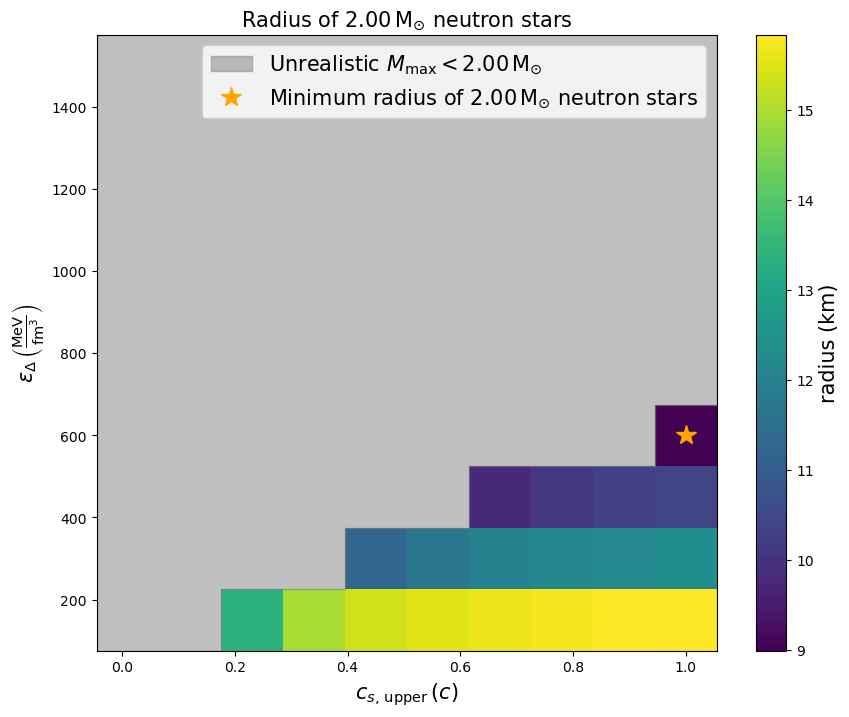

In [24]:
# Plotting radius vs EoS parameters

fig, ax = plt.subplots(figsize = (10, 8))

ax.set_title(r"Radius of $2.00\,\mathrm{M}_{\odot}$ neutron stars",
             fontsize = 15
            );

ax.set_xlabel(r"$c_{s,\,\mathrm{upper}}\,\left(c\right)$", fontsize = 15);

ax.set_ylabel(r"$\epsilon_{\Delta}\,\left(\frac{\mathrm{MeV}}{\mathrm{fm}^3}\right)$",
              fontsize = 15
             );

ax.set_xlim(-0.045, 1.055);
ax.set_ylim(75, 1575);

# radius_contour = ax.contour(c_s_upper, epsilon_delta, radii);
# ax.clabel(radius_contour);
plt.pcolormesh(c_s_upper, epsilon_delta, radii);
cbar = plt.colorbar();
cbar.set_label("radius (km)", fontsize = 15);

# Noting unrealistic mass region
ax.fill([-0.045, 0.175, 0.175, 0.395, 0.395, 0.615, 0.615, 0.945, 0.945, 1.055, 1.055, -0.045],
        [75, 75, 225, 225, 375, 375, 525, 525, 675, 675, 1575, 1575],
        color = "grey",
        alpha = 0.5,
        label = "Unrealistic $M_{\mathrm{max}}<2.00\,\mathrm{M}_{\odot}$"
       );

ax.plot(c_s_upper_constraint,
        epsilon_delta_constraint,
        marker = "*",
        color = "orange",
        linestyle = "",
        markersize = 15,
        label = r"Minimum radius of $2.00\,\mathrm{M}_{\odot}$ neutron stars"
       );

ax.legend(fontsize = 15);

# Saving plot if result is notable
plt.savefig("radius_vs_epsilon_delta_and_c_s_upper.jpg", bbox_inches = "tight");
plt.savefig("radius_vs_epsilon_delta_and_c_s_upper.pdf", bbox_inches = "tight");

In [25]:
# Adding units
epsilon_delta = epsilon_delta * u.MeV / (1 * u.fm) ** 3
radii = radii * u.km

min_radius = min_radius * u.km
epsilon_delta_constraint = epsilon_delta_constraint * u.MeV / (1 * u.fm) ** 3

In [26]:
# Displaying minimum radius and corresponding EoS parameters
print(f"The minimum radius is {min_radius:.3f}.")
print(f"The value of epsilon_delta that minimizes the radius is {epsilon_delta_constraint:.3f}.")
print(f"The value of c_s_upper that minimizes the radius is {c_s_upper_constraint:.3f}.")

The minimum radius is 8.986 km.
The value of epsilon_delta that minimizes the radius is 600.000 MeV / fm3.
The value of c_s_upper that minimizes the radius is 1.000.


In [27]:
# Printing the results
print("radii:")
print(radii)
print("epsilon_delta:")
print(epsilon_delta)
print("c_s_upper:")
print(c_s_upper)

radii:
[[        nan         nan 13.35317914 14.94497051 15.33180415 15.52336522
  15.63849341 15.71302099 15.78458191 15.8355291 ]
 [        nan         nan         nan         nan 11.21136819 11.68959768
  12.00544834 12.15599866 12.21402105 12.33972862]
 [        nan         nan         nan         nan         nan         nan
   9.73940689 10.10133694 10.29887042 10.37679428]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan  8.98571002]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan       

In [28]:
# Calculating runtime
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 4.817509889602661 seconds
